Build images and run instances

`docker-compose build`

`docker-compose up -d`

First mount the `.sql file` to your postgres_etl instance 

After that run the following command

`psql -f docker-entrypoint-initdb.d/demo_big_en_20170815.sql -U etl`

Now we'll create our Data pipeline

# Formation Interactive sur Airflow

Ce notebook guidera les apprenants à travers la construction d'un DAG dans Airflow. À chaque étape, nous allons introduire des erreurs intentionnelles qui seront corrigées dans les sections suivantes pour une meilleure compréhension.

## Étape 1: Importer les Modules Nécessaires

Pour commencer, nous allons importer les modules nécessaires au fur et à mesure que nous en aurons besoin.


In [ ]:
from airflow import DAG
from airflow.operators.empty import EmptyOperator
from airflow.utils.dates import days_ago

## Étape 2: Définir les Arguments par Défaut du DAG

Nous allons définir les arguments par défaut du DAG. Cette configuration est commune à toutes les tâches du DAG.

In [ ]:
default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': days_ago(1),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(minutes=1)
}

## Étape 3: Définir le DAG Principal

Nous définissons maintenant le DAG principal avec les arguments par défaut et les métadonnées du DAG.

In [ ]:
with DAG(
    'postgres_to_mongo_v3',
    default_args=default_args,
    description='Extract, transform and load data from PostgreSQL to MongoDB',
    schedule_interval='@daily',
    catchup=False
) as dag:
    start_task = EmptyOperator(task_id='start')


## Correction de l'Erreur

Ajoutons l'importation manquante de timedelta.

In [ ]:
from datetime import timedelta

## Étape 4: Créer les Groupes de Tâches pour l'Extraction

Nous allons créer un groupe de tâches pour extraire les données de PostgreSQL.

**Modèle logique de données**

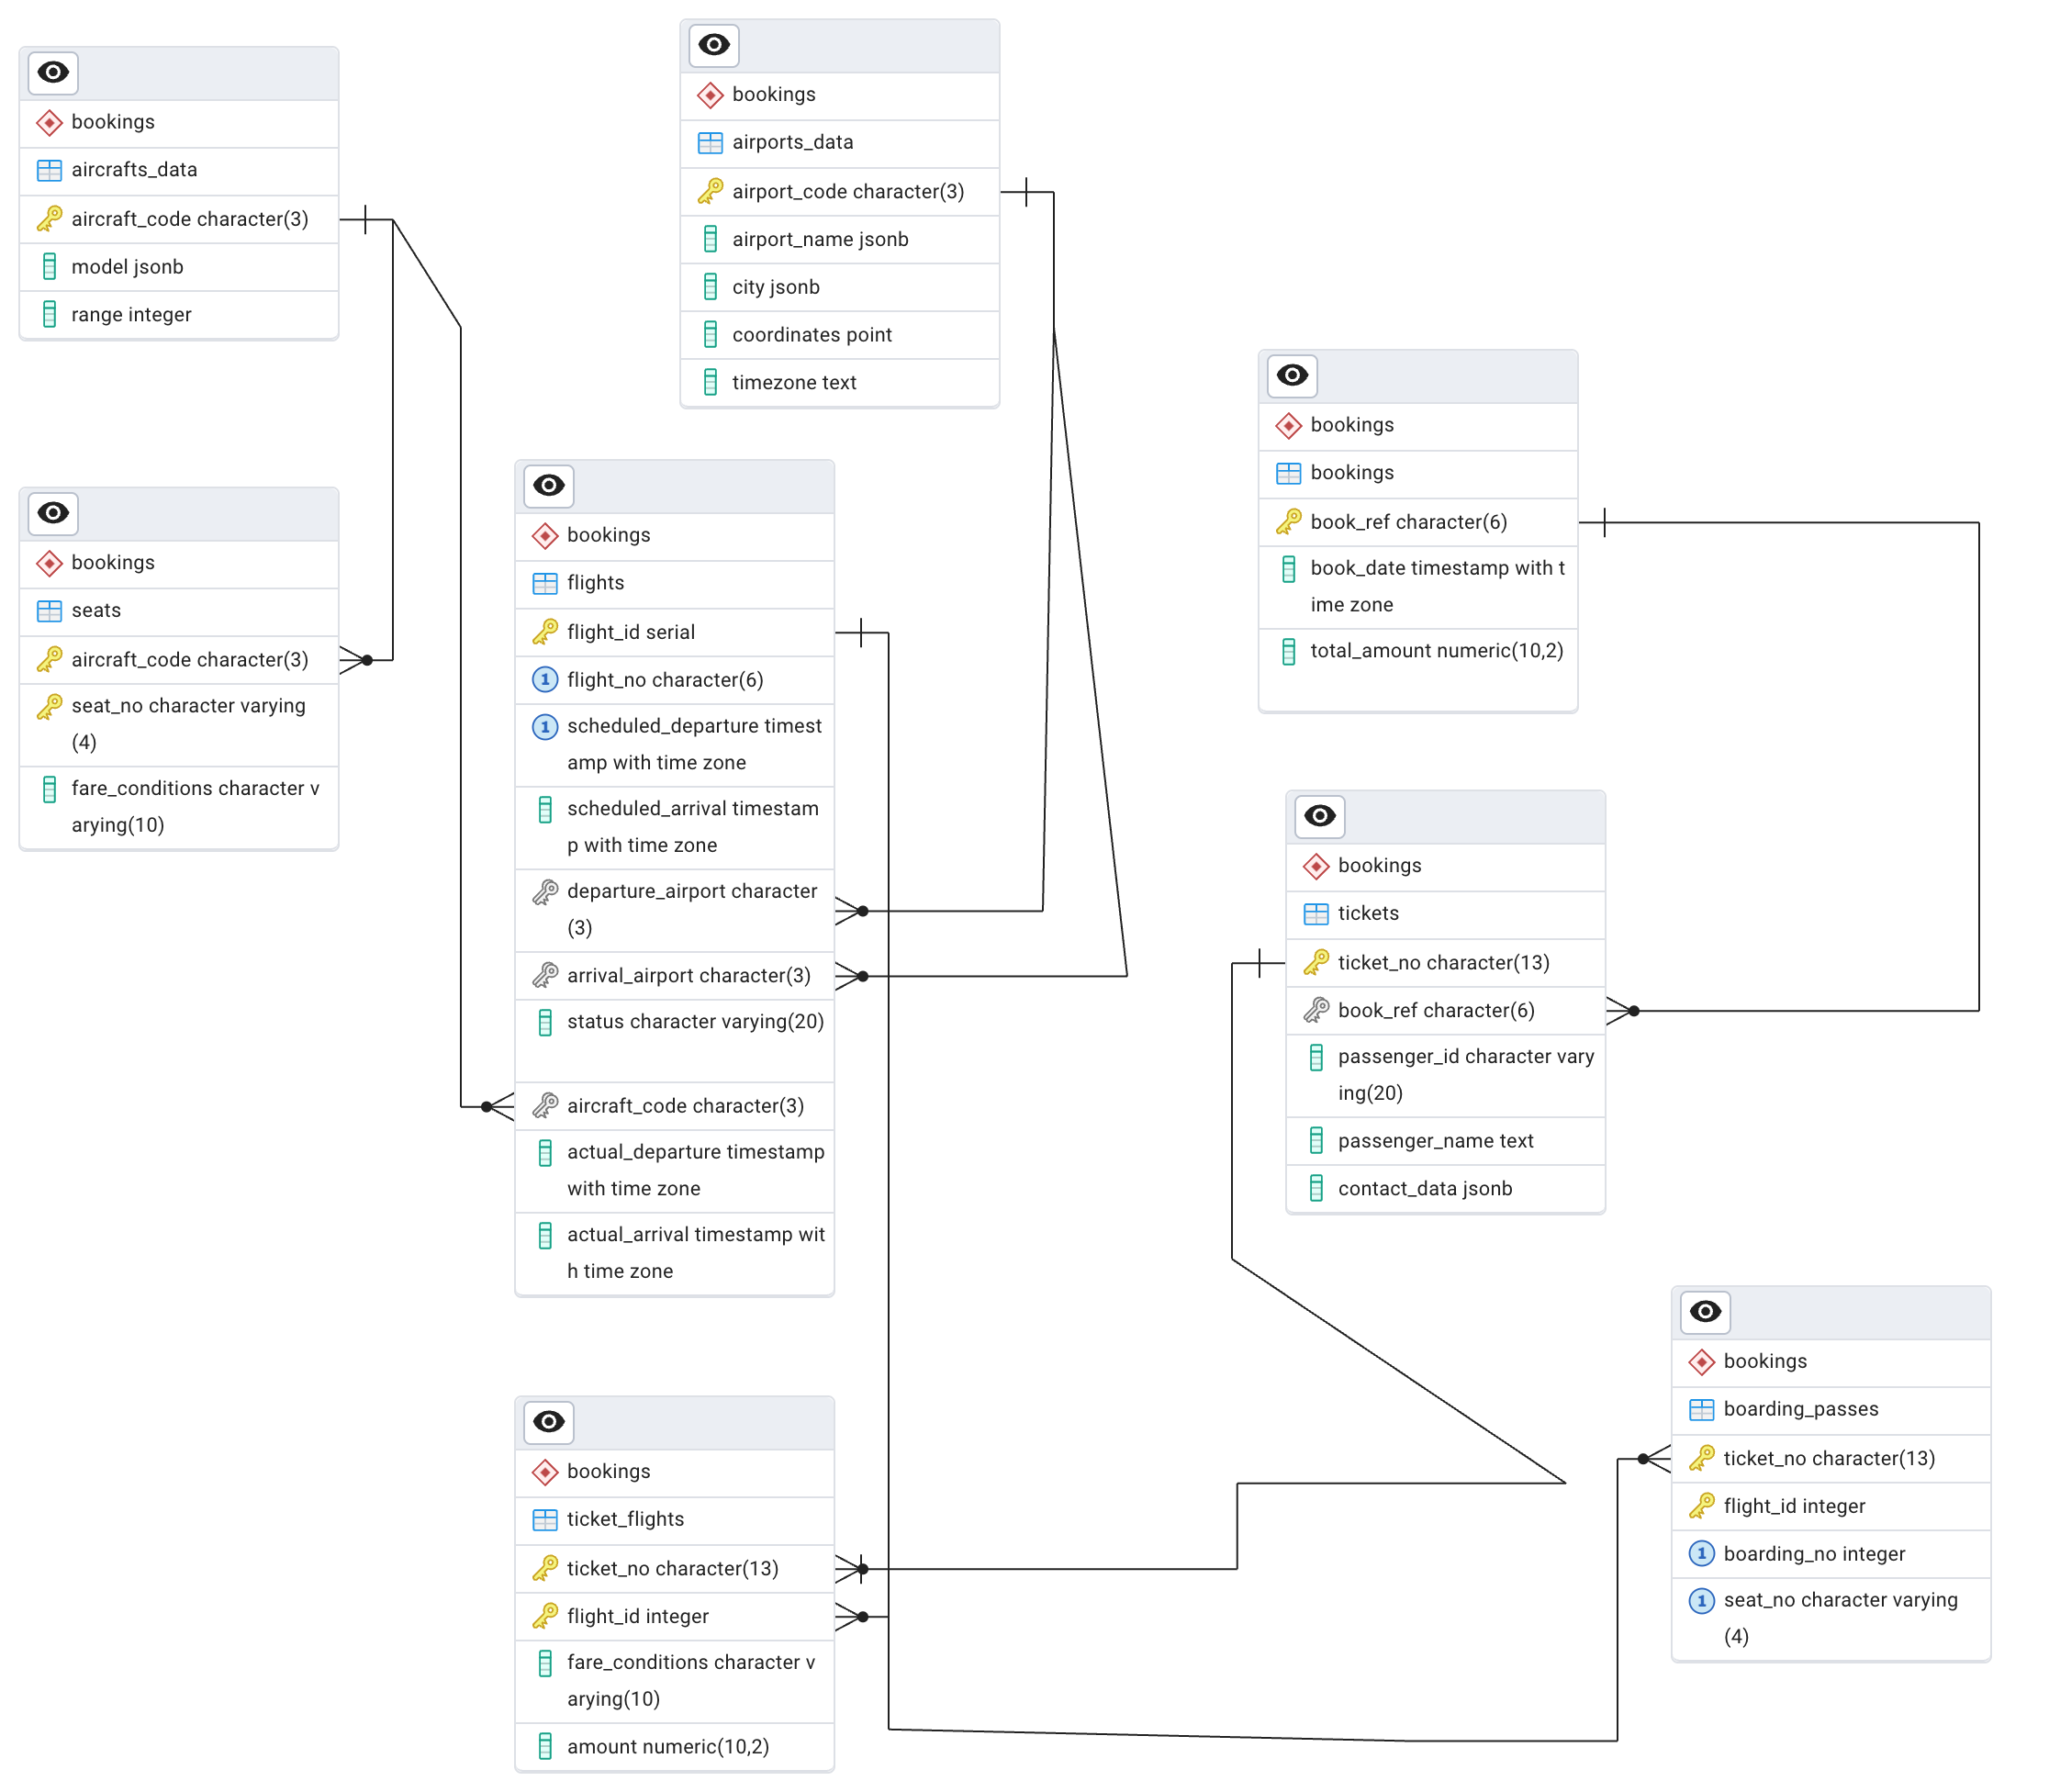

Notre objectif

➡️**Extraire les kpi suivants pour semaine en cours(Avec indicateur de comparaison par rapport à la semaine précédente)**

    -Nombre de vols

    -Nombre de vols en retard

    -Temps moyen de retard des vols

    -Nombre moyen de passagers par vols

    -Chiffre d'affaire

➡️**Visualiser**

    -Le nombre de vols par jours au fil du temps

    -Top 10 des aereports par nombre total de depart

    -Trajets des vols sur la carte

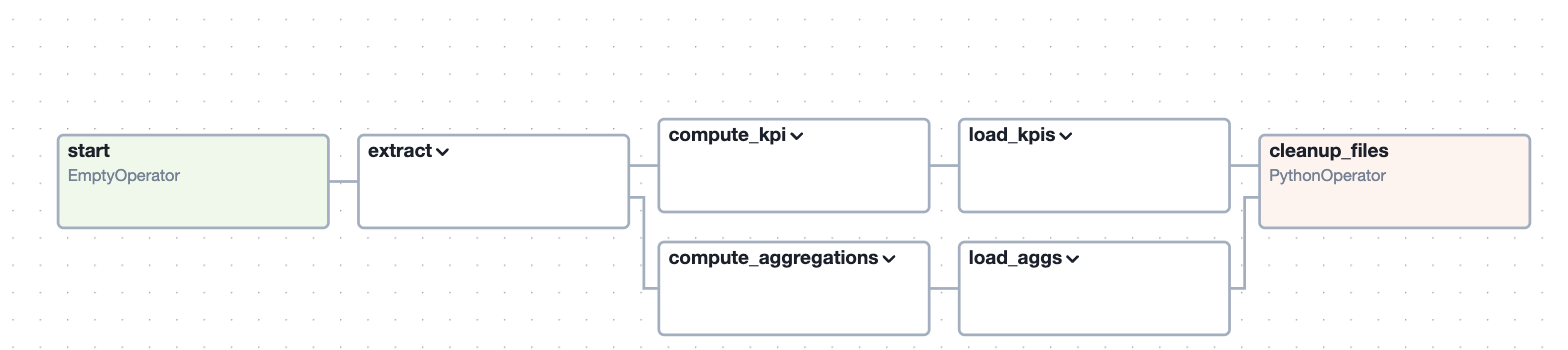

In [ ]:
tables = ["flights", "boarding_passes", "bookings", "tickets", "airports_data", "aircrafts_data", "ticket_flights"]

In [ ]:
from airflow.providers.postgres.hooks.postgres import PostgresHook
from airflow.operators.python import PythonOperator
import pandas as pd

In [ ]:
def fetch_table_from_postgres(table_name):
    pg_hook = PostgresHook(postgres_conn_id='postgres_default')
    conn = pg_hook.get_conn()
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql_query(query, conn)
    conn.close()
    file_path = f"dump/{table_name}.csv"
    df.to_csv(file_path, index=False)
    return file_path

# Taches d'extraction

In [ ]:
with TaskGroup('extract') as extract_group:
    extract_tasks = []
    for table_name in tables:
        extract_task = PythonOperator(
            task_id=f"fetch_table_from_postgres_{table_name}",
            python_callable=fetch_table_from_postgres,
            op_kwargs={'table_name': table_name}
        )
        extract_tasks.append(extract_task)

Erreur intentionnelle

In [ ]:
from airflow.utils.task_group import TaskGroup

## Étape 5: Créer les Groupes de Tâches pour le Calcul des KPIs

Nous allons créer un groupe de tâches pour calculer les KPIs.

In [ ]:
views = ["flights_over_time", "total_flights_per_week", "delayed_flights_per_week", "average_delay_time_per_week", "top_airports_by_departures", "average_passengers_per_flight_per_week", "last_week_revenue", "flights_lines"]
kpis = [v for v in views if "week" in v]
aggs = [ v for v in views if v not in kpis]

In [ ]:
view_queries = {
        "total_flights_per_week": f"""
            SELECT 
                DATE_TRUNC('day',(DATE_TRUNC('day', actual_departure) + (7 - EXTRACT(DOW FROM actual_departure)::INTEGER) * INTERVAL '1 day')) AS week_end,
                COUNT(flight_id) AS total_flights
            FROM flights
            WHERE actual_departure IS NOT NULL
            GROUP BY week_end
            ORDER by week_end DESC
            LIMIT 2;
        """,
        "delayed_flights_per_week": f"""
            SELECT
                DATE_TRUNC('day',(DATE_TRUNC('day', actual_departure) + (7 - EXTRACT(DOW FROM actual_departure)::INTEGER) * INTERVAL '1 day')) AS week_end,
                COUNT(flight_id) AS delayed_flights
            FROM flights
            WHERE actual_departure IS NOT NULL
            AND scheduled_departure < actual_departure
            GROUP BY week_end
            ORDER BY week_end DESC
            LIMIT 2;
        """,
        "flights_over_time": f"""
            SELECT 
                DATE_TRUNC('day', actual_departure) AS day,
                COUNT(flight_id) AS num_flights
            FROM flights
            WHERE actual_departure IS NOT NULL
            GROUP BY day
            ORDER BY day;
        """,
        "average_delay_time_per_week": f"""
            WITH late_times AS (
                SELECT 
                    flight_id, 
                    EXTRACT(MINUTE FROM actual_departure - scheduled_departure) AS diff_minutes
                FROM flights
                WHERE actual_departure > scheduled_departure
            )
            SELECT 
                DATE_TRUNC('day',(DATE_TRUNC('day', actual_departure) + (7 - EXTRACT(DOW FROM actual_departure)::INTEGER) * INTERVAL '1 day')) AS week_end,
                AVG(late_times.diff_minutes) AS average_delay_minutes
            FROM late_times, flights f
            WHERE actual_departure IS NOT NULL
            AND late_times.flight_id = f.flight_id
            GROUP BY week_end
            ORDER BY week_end DESC
            LIMIT 2;
        """,
        "top_airports_by_departures": f"""
            SELECT 
                a.airport_code, 
                a.airport_name, 
                COUNT(f.flight_id) AS num_departures
            FROM flights f, airports_data a
            WHERE f.departure_airport = a.airport_code
            GROUP BY a.airport_code, a.airport_name
            ORDER BY num_departures DESC
            LIMIT 10;
        """,
        "average_passengers_per_flight_per_week": f"""
            WITH nb_pss AS (
                SELECT 
                    f.flight_id, 
                    COUNT(b.*) AS nb_pass
                FROM flights f
                JOIN boarding_passes b ON f.flight_id = b.flight_id
                GROUP BY f.flight_id
            )
            SELECT
                DATE_TRUNC('day',(DATE_TRUNC('day', actual_departure) + (7 - EXTRACT(DOW FROM actual_departure)::INTEGER) * INTERVAL '1 day')) AS week_end,
                AVG(nb_pss.nb_pass) AS average_passengers
            FROM flights f
            JOIN nb_pss ON f.flight_id = nb_pss.flight_id
            WHERE actual_departure IS NOT NULL
            GROUP BY week_end
            ORDER BY week_end DESC
            LIMIT 2;
        """,
        "last_week_revenue": f"""
            SELECT 
                DATE_TRUNC('day',(DATE_TRUNC('day', book_date) + (7 - EXTRACT(DOW FROM book_date)::INTEGER) * INTERVAL '1 day')) AS week_end,
                SUM(total_amount) AS total_revenue
            FROM bookings
            WHERE NOT EXISTS(SELECT * FROM tickets WHERE book_ref = bookings.book_ref)
            GROUP BY week_end
            ORDER BY week_end DESC
            LIMIT 2;
        """,
        "flights_lines": f"""
            WITH lines AS(
                SELECT
                    d.city AS departure_city,
                    d.coordinates AS departure_coordinates,
                    a.city AS arrival_city,
                    a.coordinates AS arrival_coordinates,
                    DATE_TRUNC('day',(DATE_TRUNC('day', actual_departure) + (7 - EXTRACT(DOW FROM actual_departure)::INTEGER) * INTERVAL '1 day')) AS week_end,
                FROM flights f, airports_data d, airports_data a
                WHERE f.departure_airport = d.airport_code
                AND f.arrival_airport = a.airport_code
            ),
            weeks AS(
                SELECT
                    DATE_TRUNC('day',(DATE_TRUNC('day', actual_departure) + (7 - EXTRACT(DOW FROM actual_departure)::INTEGER) * INTERVAL '1 day')) AS week_end,
                FROM flights
                LIMIT 1
            )
            SELECT
                departure_city,
                departure_coordinates,
                arrival_city,
                arrival_coordinates
            FROM lines, weeks
            WHERE lines.week_end = weeks.week_end;

        """,
    }


In [ ]:
import duckdb as db
import json
from datetime import datetime, date

In [ ]:
def compute(view_name):
    flights = db.read_csv("dump/flights.csv")
    file_path = f"dump/{view_name}.json"
    columns = [desc[0] for desc in db.sql(view_queries[view_name]).description]
    rows = db.sql(view_queries[view_name]).fetchall()
    data = [dict(zip(columns, row)) for row in rows]
    with open(file_path, 'w') as f:
        json.dump(data, f)
    return file_path

In [ ]:
from decimal import Decimal

In [ ]:
def decimal_default(obj):
    if isinstance(obj, Decimal):
        return str(obj)
    if isinstance(obj, (datetime, date)):
        return obj.isoformat()
    raise TypeError(f"Type {type(obj)} not serializable")

In [ ]:
def compute(view_name):
    flights = db.read_csv("dump/flights.csv")
    file_path = f"dump/{view_name}.json"
    columns = [desc[0] for desc in db.sql(view_queries[view_name]).description]
    rows = db.sql(view_queries[view_name]).fetchall()
    data = [dict(zip(columns, row)) for row in rows]
    with open(file_path, 'w') as f:
        json.dump(data, f, default=decimal_default)
    return file_path

In [ ]:
with TaskGroup('compute_kpi') as compute_kpi_group:
    compute_kpi_tasks = []
    for kpi in kpis:
        compute_task = PythonOperator(
            task_id=f"compute_{kpi}",
            python_callable=compute,
            op_kwargs={'view_name': kpi}
        )
        compute_kpi_tasks.append(compute_task)

In [ ]:
with TaskGroup('compute_aggregations') as compute_aggs_group:
        compute_agg_tasks = []
        for agg in aggs:
            compute_task = PythonOperator(
                task_id=f"compute_{agg}",
                python_callable=compute,
                op_kwargs={'view_name': agg}
            )
            compute_agg_tasks.append(compute_task)

## Étape 6: Créer les Groupes de Tâches pour le Chargement dans MongoDB

Nous allons créer un groupe de tâches pour charger les données dans MongoDB.

In [ ]:
from airflow.providers.mongo.hooks.mongo import MongoHook

In [ ]:
def load_to_mongo(view_name, file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    mongo_hook = MongoHook(conn_id="mongo_flights")
    client = mongo_hook.get_conn()
    db = client["kpi_graph"]
    collection = db[view_name]
    collection.delete_many({})
    if data:
        collection.insert_many(data)
    client.close()
    return file_path

In [ ]:
with TaskGroup('load_kpis') as load_kpis_group:
    load_kpis_tasks = []
    for kpi in kpis:
        load_task = PythonOperator(
            task_id=f"load_{kpi}_to_mongo",
            python_callable=load_to_mongo,
            op_kwargs={'view_name': kpi, 'file_path': f"dump/{kpi}.json"}
        )
        load_kpis_tasks.append(load_task)

In [ ]:
with TaskGroup('load_aggs') as load_aggs_group:
        load_aggs_tasks = []
        for agg in aggs:
            load_task = PythonOperator(
                task_id=f"load_{agg}_to_mongo",
                python_callable=load_to_mongo,
                op_kwargs={'view_name': agg, 'file_path': f"dump/{agg}.json"}
            )
            load_aggs_tasks.append(load_task)

## Étape 7: Ajouter la Tâche de Nettoyage

Nous ajoutons une tâche pour nettoyer les fichiers temporaires après le chargement.

In [ ]:
import os

In [ ]:
def cleanup_files():
    for file in os.listdir('dump'):
        file_path = os.path.join('dump', file)
        if os.path.exists(file_path):
            os.remove(file_path)

In [ ]:
cleanup_task = PythonOperator(
    task_id='cleanup_files',
    python_callable=cleanup_files
)

## Étape 8: Définir les Dépendances

Nous définissons les dépendances entre les tâches.

In [ ]:
start_task >> extract_group >> compute_kpi_group >> load_kpis_group >> cleanup_task
extract_group >> compute_aggs_group >> load_aggs_group >> cleanup_task

## ___________________________________________________________________